In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# custom package
import plotting_tools as pt
%matplotlib inline

from matplotlib.patches import Ellipse
from scipy.stats import norm

# this is a module I created
from cluster_methods import *

from sklearn import decomposition
import skfuzzy as fuzz
from sklearn import preprocessing
from sklearn import manifold

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

import kcorrect

from scipy import linalg

from sklearn.mixture import GMM
    
# exploring the properties of galaxies through multidimensional statistical analysis techniques 
# vespa data, galaxy zoo data, sdss
# 0: stellar mass
# 1: error
# 2: SFR last 115 Myr
# 3: dustVal ISM
# 4: metallicity
# 5: redshift
# 6: prob. elliptical
# 7: prob. spiral
# 8: prob. merger
# 9: u
# 10: g
# 11: r
# 12: i
# 13: z
# 14: u err
# 15: g err
# 16: r err
# 17: i err
# 18: z err
# 19: petro r
# 20: theta

# preprocessing, k-corrections, normalising data, cluster analysis

In [2]:
kcorrect.load_templates()
kcorrect.load_filters()

def perform_kcorrect(redshift,magnitudes,mag_ivars):
    # remember to apply AB magnitude offsets if required
    maggies = pow(10,-0.4*np.array(magnitudes))
    maggies_ivar = pow(0.4*np.log(10)*maggies*np.array(mag_ivars),-2)
    c = kcorrect.fit_nonneg(redshift,maggies,maggies_ivar)
    rm = kcorrect.reconstruct_maggies(c)
    rm0 = kcorrect.reconstruct_maggies(c,redshift=0.)
    return -2.5*np.log10(rm[1:]/rm0[1:])   

In [3]:
# load galaxies
galaxies = np.load('/home/calum/Documents/Mphys_data/vespa_data/final_vespa_properties.npy')
galaxies.shape

(417270, 21)

In [4]:
rlim_galaxies = np.array([row for row in galaxies if 0.09>row[5]>0.004])
rlim_galaxies.shape

(172532, 21)

In [5]:
# plot un kcorrected CMD and remove obvious outliers
x = [(row[19])-5*(np.log10(cosmo.luminosity_distance(row[5]).to(u.pc).value/10)) for row in rlim_galaxies]
y = [row[9]-row[11] for row in rlim_galaxies]

In [6]:
len(x)

172532

(-23, -16)

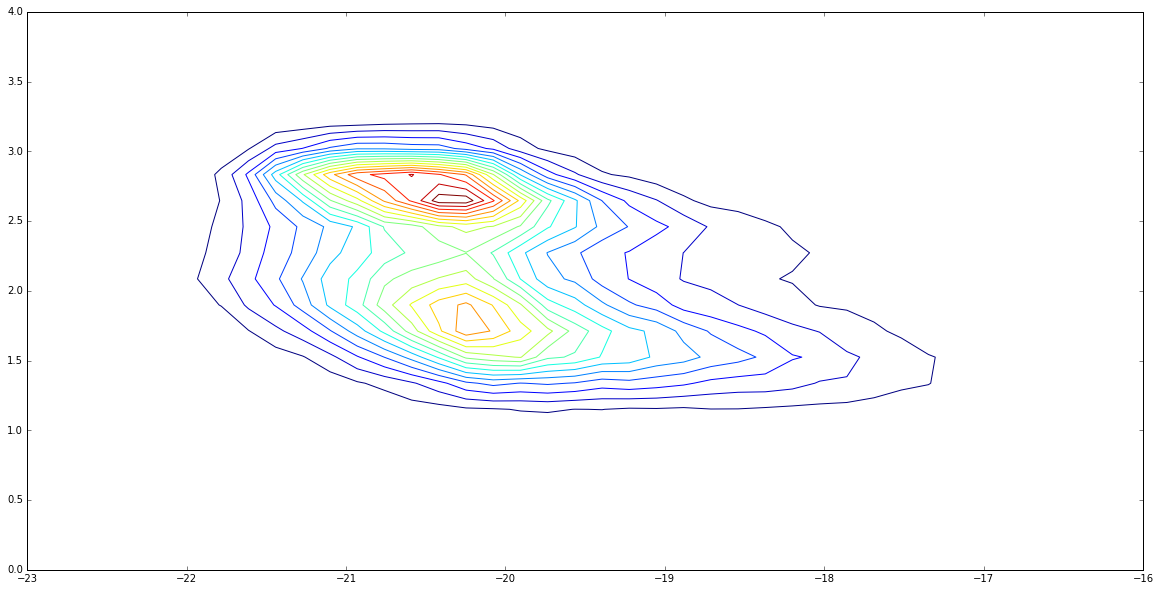

In [7]:
plt.figure(figsize=(20,10))
pt.plot_contour(x,y,bins=70)
plt.ylim(0.,4.)
plt.xlim(-23,-16)

In [8]:
kcorrections = []

for row in rlim_galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[5],row[9:14],row[14:19])
    # store k-corrections
    kcorrections.append([row[5],ktuple]) 

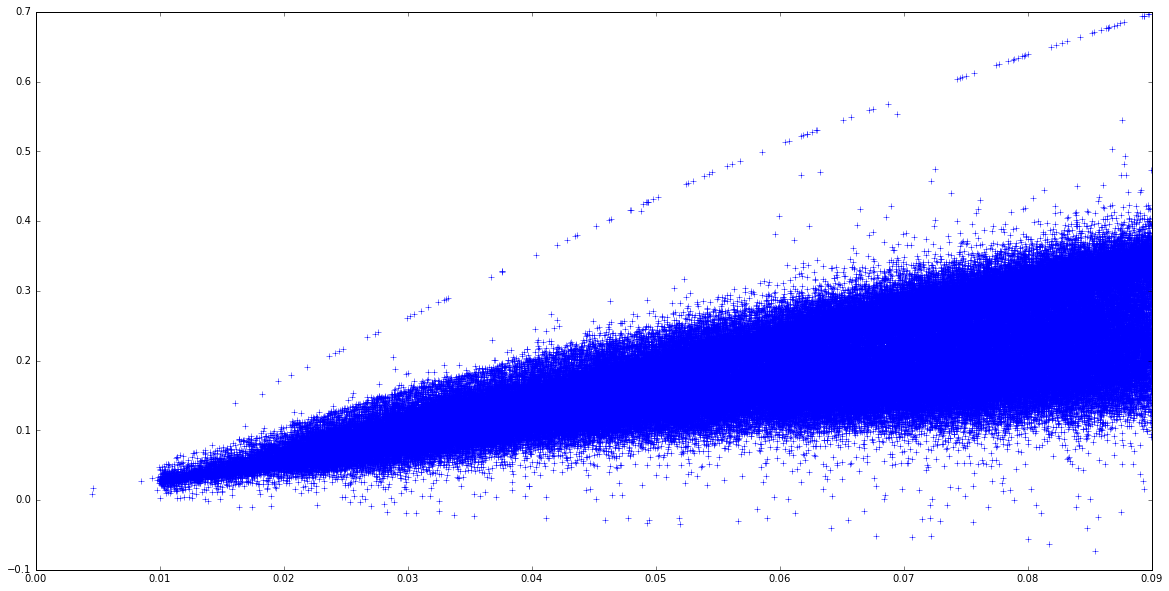

In [9]:
plt.figure(figsize=(20,10))
plt.plot([row[0] for row in kcorrections],[row[1][0] for row in kcorrections],'+')

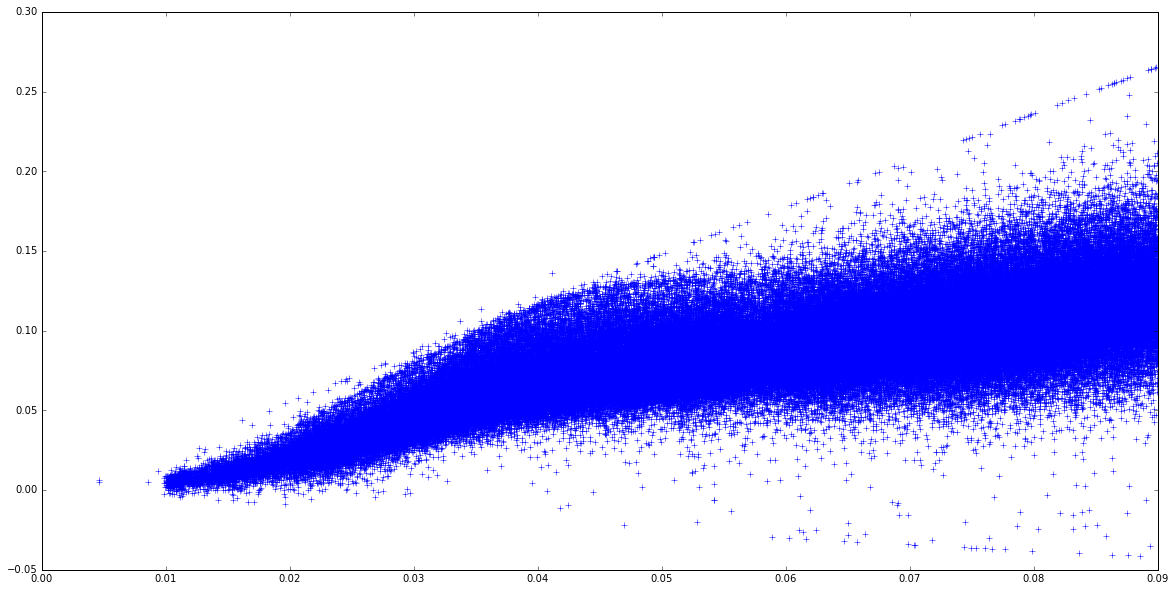

In [10]:
plt.figure(figsize=(20,10))
plt.plot([row[0] for row in kcorrections],[row[1][2] for row in kcorrections],'+')

In [11]:
len(y), len(kcorrections)

(172532, 172532)

In [12]:
kcorrect_y = []
kcorrect_x = []

for i,row in enumerate(y):
    kcorrect_x.append(x[i]-kcorrections[i][1][2])
    kcorrect_y.append(row-kcorrections[i][1][0]+kcorrections[i][1][2])

(-22.5, -16.5)

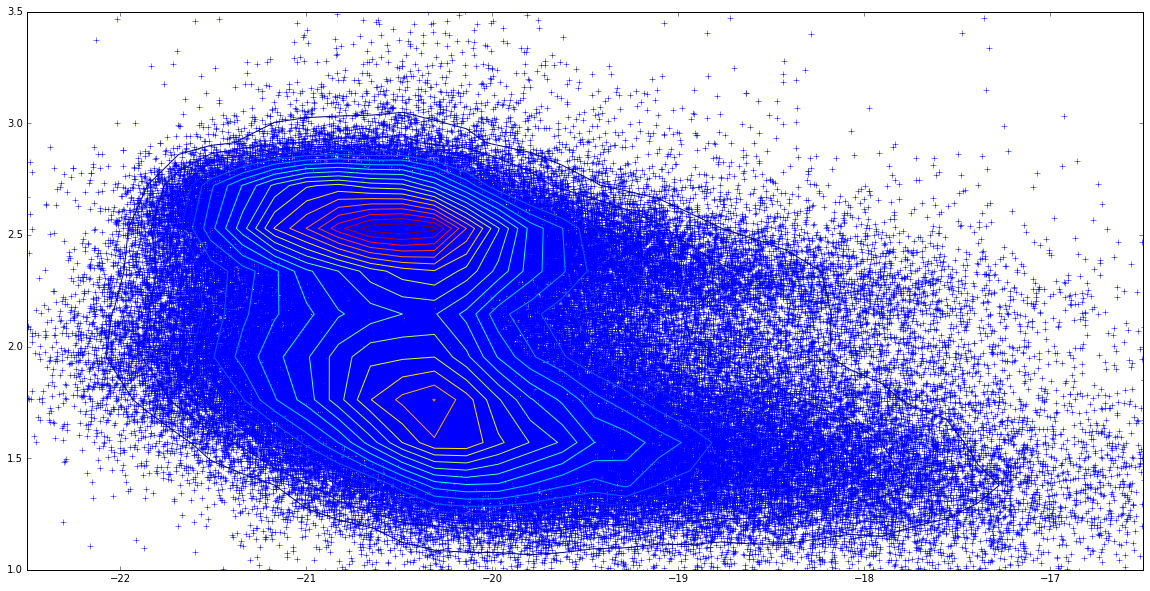

In [13]:
plt.figure(figsize=(20,10))
pt.plot_contour(kcorrect_x,kcorrect_y,bins=70)
plt.plot(kcorrect_x,kcorrect_y,'+')
plt.ylim(1.,3.5)
plt.xlim(-22.5,-16.5)

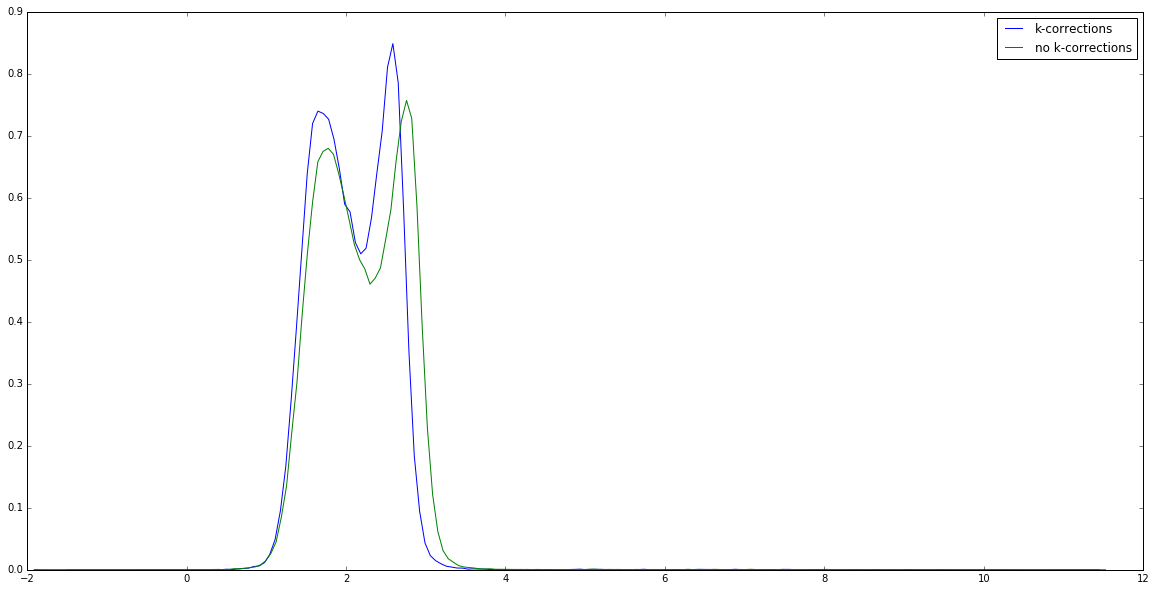

In [14]:
plt.figure(figsize=(20,10))
pt.plot_hist(kcorrect_y,200,'k-corrections')
pt.plot_hist(y,200,'no k-corrections')
plt.legend()

In [15]:
# remove outliers, only removes 500 obvious outliers
reduced_rlim_galaxies = []

for i, row in enumerate(rlim_galaxies):
    if -22.5 < kcorrect_x[i] < -15.5:
        if 0.5 < kcorrect_y[i] < 3.6:
            reduced_rlim_galaxies.append(row)    
            
len(reduced_rlim_galaxies)

171992

In [16]:
# do kcorections again
kcorrections = []

for row in reduced_rlim_galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[5],row[9:14],row[14:19])
    # store k-corrections
    kcorrections.append([row[5],ktuple]) 

In [17]:
# define dataset
data = []

#create dataset for clustering
for i,row in enumerate(reduced_rlim_galaxies):
    # absolute r-band petrosian magnitude
    x0 = float(row[19])-5*(np.log10(cosmo.luminosity_distance(row[5]).to(u.pc).value/10))-kcorrections[i][1][2]
    # k-corrected (u-r) colour
    x1 = row[9]-row[11]-kcorrections[i][1][0]+kcorrections[i][1][2]
    # redshift
    x2 = row[4]
    # morphological parameters
    x3 = 0
    x4 = 0
    x5 = 0
    if row[6] > 0.8:
        x3 = 1            
    if row[7] > 0.8:
        x4 = 1
    if row[8] > 0.8:
        x5 = 1
    # ISM dust value
    x6 = row[3]
    # log(stellar mass)
    x7 = np.log(row[0])
    # SFR last 115 Myr
    x8 = row[2]
    # metallicity average in last 5 age bins (115 Myr)
    x9 = row[4]
        
    # append to data
    data.append([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9])

In [18]:
data = np.array(data)
data.shape

(171992, 10)

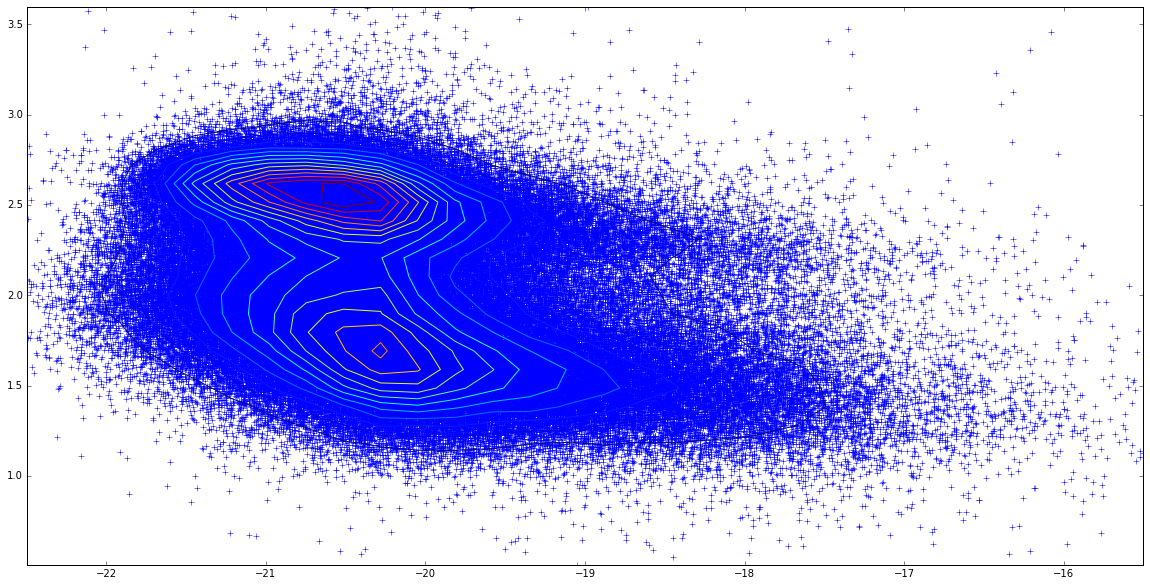

In [19]:
plt.figure(figsize=(20,10))
pt.plot_contour([row[0] for row in data],[row[1] for row in data],bins=30)
plt.plot([row[0] for row in data],[row[1] for row in data],'+')

In [20]:
# scale data before manifold learning
# select rows that will be used for clustering
data_clustering = [ [row[0],row[1],row[3],row[4],row[5],row[6],row[7]] for row in data]
data_scaled = preprocessing.scale(data)

/home/calum/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


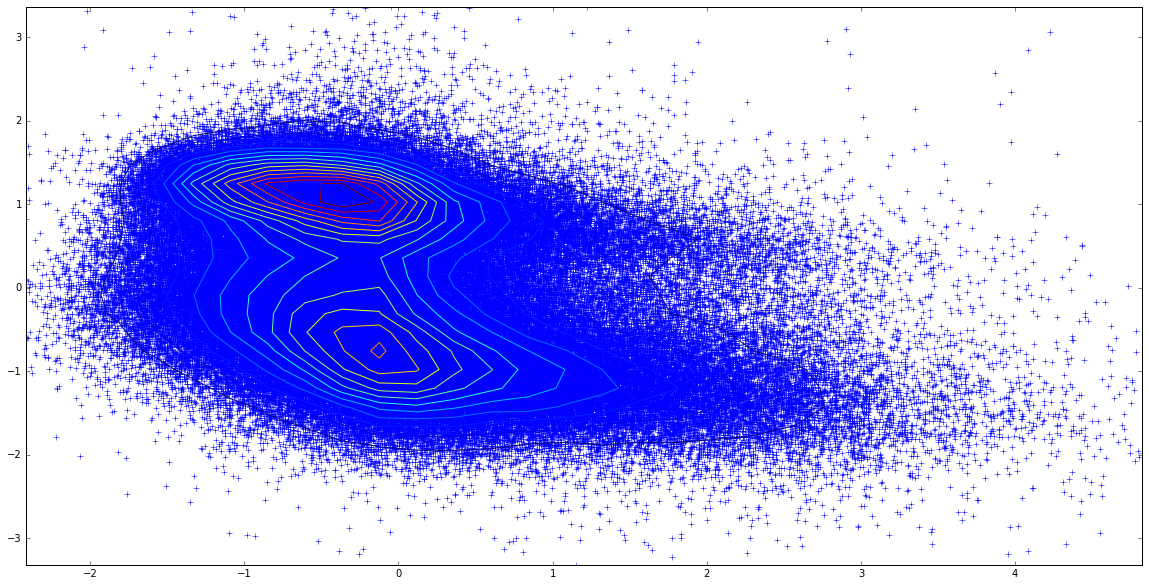

In [21]:
plt.figure(figsize=(20,10))
pt.plot_contour([row[0] for row in data_scaled],[row[1] for row in data_scaled],bins=30)
plt.plot([row[0] for row in data_scaled],[row[1] for row in data_scaled],'+')

In [28]:
sample_number = np.random.choice(np.array([i for i  in range(0,171992)]),15000)

In [31]:
sample_number[:10]

array([ 12856,  80173,  98064, 136774,  15425, 148533, 119813,  17551,
        91766,  36471])

In [34]:
# use manifold learning technique Modified Locally Linear Embedding
data_r = manifold.LocallyLinearEmbedding(n_neighbors=12,n_components=5).fit_transform(data_scaled[sample_number])

(15000, 5)

In [ ]:
# perform fuzzy cluster analysis

In [ ]:
print('hello')

In [33]:
data_scaled[sample_number].shape

(15000, 10)